In [1]:
import numpy as np
import sys
sys.path.append("..")
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
from data_loaders import *
from missing_process.block_rules import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier


In [2]:


real_datalist = [
    "banknote",
        "concrete_compression",
            "wine_quality_white","wine_quality_red",
            "california","climate_model_crashes",
            "connectionist_bench_sonar","qsar_biodegradation",
            "yeast","yacht_hydrodynamics"
            ]

missingtypelist = [
                    "quantile",
                   "diffuse",
                   "logistic"
                   ]

seed = 1
nfold = 5

In [3]:
def load_impute_data(missingtype,model_name,rule_name,dataname,fold,seed = 1):
    if model_name == "tabcsdi" and missingtype in ["mcar","mar"]:
        train_impute = np.load(f'impute_hpc/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_train.npy')
        test_impute = np.load(f'impute_hpc/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_test.npy')
        return train_impute,test_impute


    train_impute = np.load(f'impute/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_train.npy')
    test_impute = np.load(f'impute/{missingtype}/{dataname}/{model_name}/{rule_name}_seed-{seed}_{fold}_test.npy')
    return train_impute,test_impute

def load_train_test(index_file,norm_values,observed_masks,label_values):  

    train_index = index_file["train_index"]
    test_index = index_file["test_index"]

    train_values = norm_values[train_index,:]

    train_masks = observed_masks[train_index,:]

    test_values = norm_values[test_index,:]

    test_masks = observed_masks[test_index,:]


    train_label = label_values[train_index]

    test_label = label_values[test_index]

    return train_values,train_masks,train_label,test_values,test_masks,test_label


def process_target(dataname,y):
    if dataname in ["concrete_compression",
            "wine_quality_white","wine_quality_red",
            "california","yacht_hydrodynamics"
            ]:
        return y,"reg"
    
    else:
        encoder = LabelEncoder()
        y_encoded = encoder.fit_transform(y.reshape(-1, 1))
        return y_encoded,"clf"
    

In [4]:
def fillin_imputed_data(imputed,mask,original):
    filled_data = np.where(mask == 1, original, imputed)
    return filled_data

In [5]:
fillin_imputed_data(np.array([1,2,3]),np.array([1,0,0]),np.array([4,5,6]))

array([4, 2, 3])

In [289]:



def run_ml(rule_name,model_number,missingtype,datalist,task_type ="reg",mode = "itit",baseline = False):


    for dataname in tqdm(datalist):
        
        directory_path = f"datasets/{dataname}"
        data = dataset_loader(dataname)    
        norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
        label_values, task_type = process_target(dataname,data["target"])

        if task_type =="reg":
           ml_model_list = [Ridge(), MLPRegressor(random_state=1), SVR()]
           
        else:
            ml_model_list = [RandomForestClassifier(n_estimators=100, random_state=42),LogisticRegression(random_state=1), MLPClassifier(random_state=1), SVC()]
            ml_model_list = [SVC()]

        model = ml_model_list[model_number]

        observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')
        f = open(f'{directory_path}/split_index_cv_seed-{seed}_nfold-{nfold}.json')
        index_file = json.load(f)


        svm_list = {}
        svm_list["Complete"] = {}
        impute_value = {}
        for model_name in model_name_list:
            display_name = display_name_dic[model_name]
            svm_list[display_name] = {}
            # load data and its mask
            f1_rmse_list = []
            acc_r2_list = []
            for fold in index_file:

                index = index_file[fold]
                train_values,train_masks,train_label,test_values,test_masks,test_label = load_train_test(index,norm_values,observed_masks,label_values)

                impute_train,impute_test  = load_impute_data(missingtype,model_name,rule_name,dataname,fold)

                impute_test = fillin_imputed_data(impute_test,test_masks,test_values)
                impute_test = np.nan_to_num(impute_test, nan=0)

                evl1,evl2,clf = model_eval(train_label, impute_train, test_values, test_label, task_type,model)

                f1_rmse_list.append(evl1)
                acc_r2_list.append(evl2)

                impute_value[display_name] = impute_test

                # make_feature_importance(clf,impute_train,model_name)
                myrmse = calculate_rmse(impute_test,test_values, test_masks)

                perm_importance = svm_importance(clf,impute_test,test_label)
                svm_list[display_name]["svm"] = perm_importance
                svm_list[display_name]["rmse"] = myrmse

                break
                
            svm_list[display_name]["f1"] = np.mean(f1_rmse_list)
            svm_list[display_name]["acc"] = np.mean(acc_r2_list)


        evl1,evl2,clf = model_eval(train_label, train_values, test_values, test_label, task_type,model)

        impute_value["Complete"] = test_values
        make_scatter(test_values,impute_value,test_masks,test_label)
        rmse = calculate_rmse(test_values,test_values, test_masks)

        perm_importance = svm_importance(clf,impute_test,test_label)
        svm_list["Complete"]["svm"] = perm_importance
        svm_list["Complete"]["rmse"] = rmse
        svm_list["Complete"]["f1"] = evl1
        svm_list["Complete"]["acc"] = evl2


    svm_importance_plot(svm_list)

    svm_list = pd.DataFrame(svm_list).T






  0%|          | 0/1 [00:00<?, ?it/s]d:\miniconda3\envs\py3.10\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


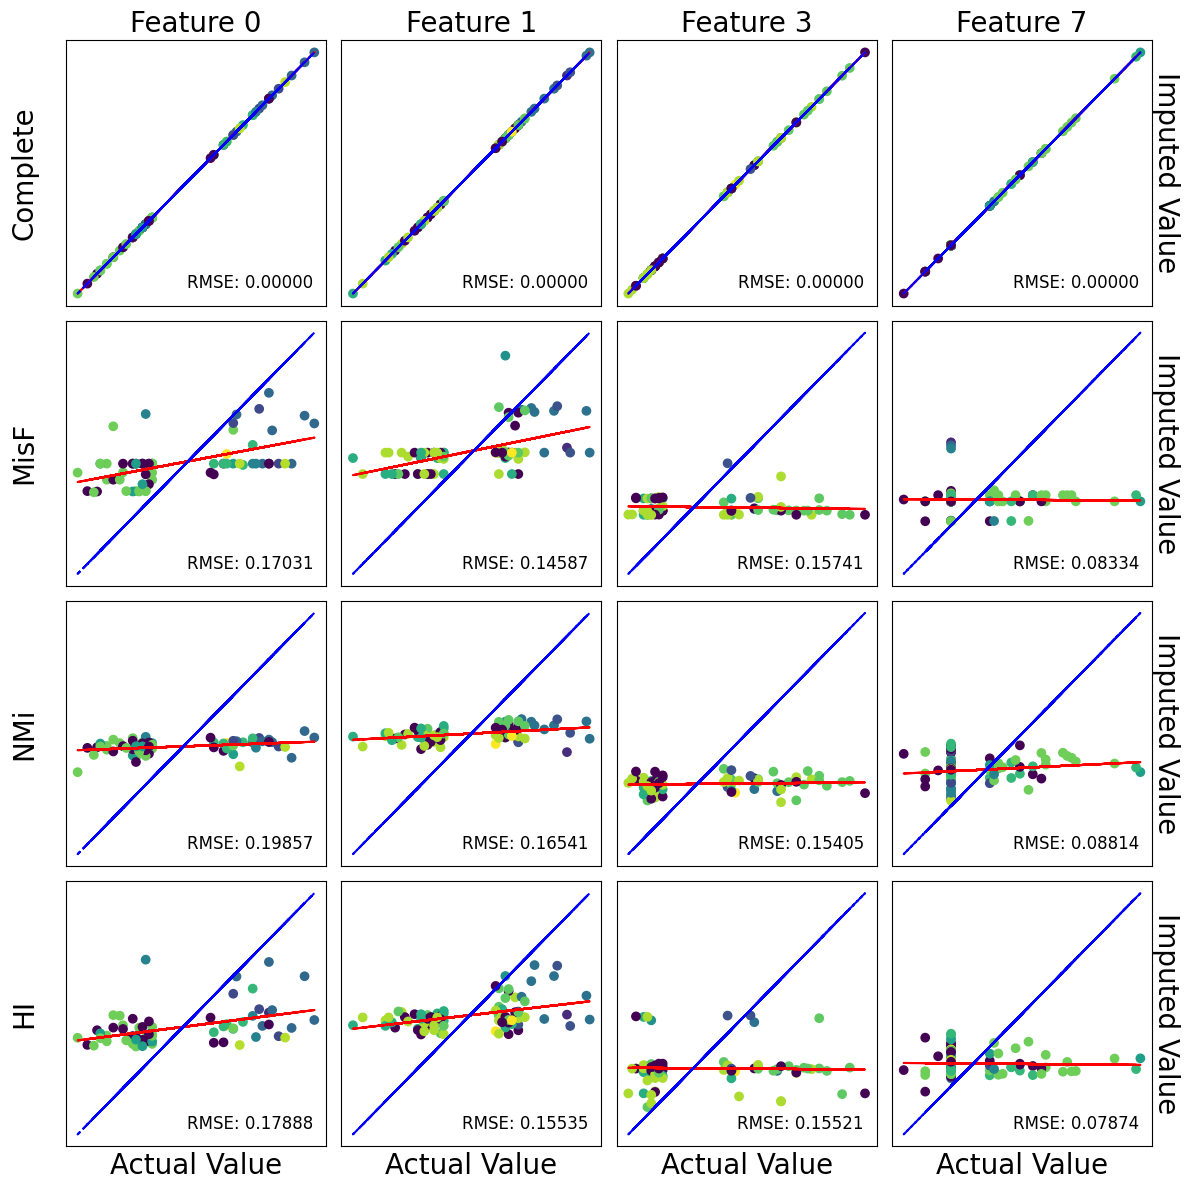

100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


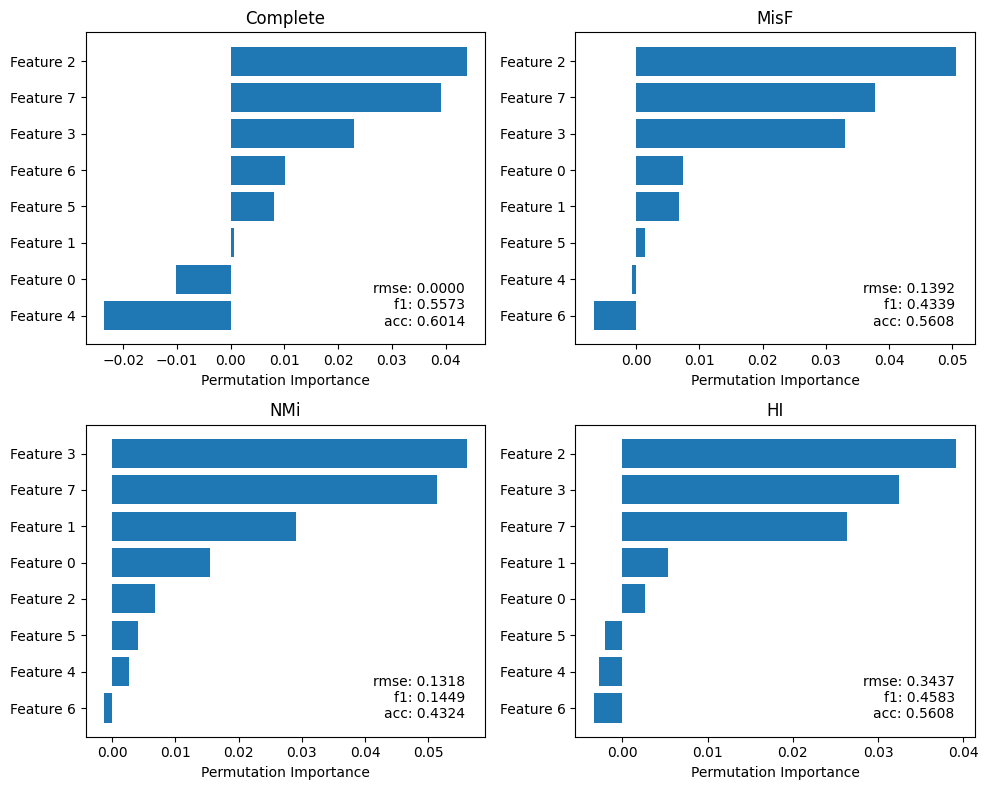

In [301]:
real_datalist = ["banknote",
            "california","climate_model_crashes","concrete_compression",
           "qsar_biodegradation","wine_quality_red", "connectionist_bench_sonar","wine_quality_white",
            "yacht_hydrodynamics","yeast"
            ]

model_name_list = ["random", "zero", "mean", "knn", "mf", "mice", "missforest", "XGB", "ot", "hyper", "gain", "miwae", "notmiwae", "tabcsdi"]

model_name_list = ["missforest","notmiwae","tabcsdi"]

display_name_dic = {"missforest":"MisF","miwae":"Mi","tabcsdi":"CSDI","notmiwae":"NMi","hyper":"HI"}


clf_data =  ["yeast"]
#clf_data =  ["banknote"]
missingtype = "mcar"
rule_name = 0.5
model_number = 0

missingtype = "quantile"
rule_name = "Q1_Q4_0.5"
model_name_list = ["missforest","notmiwae","hyper"]
run_ml(rule_name,model_number,missingtype,clf_data,task_type ="clf",mode = "itft")


In [10]:
import numpy as np
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, r2_score

def model_eval(label_train, impute_train, impute_test, label_test, task_type,model):
    #print(task_type)
    if task_type == "reg":
        # Define regressors
        reg = model
        
        # Check for NaNs

        reg.fit(impute_train, label_train)
        y_pred_test = reg.predict(impute_test)



        test_rmse = np.sqrt(mean_squared_error(label_test, y_pred_test))
        r2 = r2_score(label_test, y_pred_test)
        return test_rmse,r2

    else:
        # Define classifiers

        clf = model
        # Evaluate each classifier and store F1 scores for both train and test

        clf.fit(impute_train, label_train)


        y_pred_test = clf.predict(impute_test)
   
        # Calculate average F1 score
        test_f1 = f1_score(label_test, y_pred_test, average='macro')
        accuracy = accuracy_score(label_test, y_pred_test)
        return test_f1, accuracy, clf


In [300]:
import matplotlib.pyplot as plt
import numpy as np

def make_feature_importance(forest,X,title):
    
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots(figsize=(6, 4))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(title)
    #ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()




# def make_scatter(actual_values, imputed_values_list, test_masks,test_label, column_indices = [0, 1, 2, 3]):
#     # Define the number of rows and columns for subplots

#     for title, imputed_values in imputed_values_list.items():
#         num_cols = len(column_indices)
#         num_rows = 1

#         # Create a figure and subplots
#         fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4))

#         # Flatten the axes array to easily access each subplot
#         axs = axs.flatten()

#         # Iterate over each column index
#         for i, col in enumerate(column_indices):
#             # Create scatter plot for imputed vs actual values for each column
#             actual_column = actual_values[:, col]
#             imputed_column = imputed_values[:, col]

#             mask_column = test_masks[:, col]

#             act_col = actual_column[mask_column == 0]
#             imp_col = imputed_column[mask_column == 0]       

#             axs[i].scatter(act_col, imp_col, alpha=0.5, c=test_label[mask_column == 0], cmap='viridis')
            
#             # Set labels and title for each subplot
#             axs[i].set_xlabel('Actual Values')
#             axs[i].set_ylabel('Imputed Values')
#             axs[i].set_title(f'Column {col+1}')

#             # Add best-fit line
#             m, b = np.polyfit(act_col, imp_col, 1)
#             axs[i].plot(act_col, m * act_col + b, color='red')

#             # Add diagonal line
#             axs[i].plot(act_col, act_col, color='blue', linestyle='--')

#         # Adjust layout
#         plt.suptitle(title)
#         plt.tight_layout()

#         # Show the plot
#         plt.show()


import numpy as np
import matplotlib.pyplot as plt

def make_scatter(actual_values, imputed_values_list, test_masks, test_label, 
                 column_indices=[0, 1, 3,7]
                 #column_indices=[4,5, 6, 7]
                 ):
    num_cols = len(column_indices)
    num_rows = len(imputed_values_list)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))
    imputed_values_list = reorder_last_to_first(imputed_values_list)
    for i, (title, imputed_values) in enumerate(imputed_values_list.items()):
        axs_row = axs[i]
        for j, col in enumerate(column_indices):
            actual_column = actual_values[:, col]
            imputed_column = imputed_values[:, col]

            mask_column = test_masks[:, col]

            act_col = actual_column[mask_column == 0]
            imp_col = imputed_column[mask_column == 0]

            ax = axs_row[j]
            ax.scatter(act_col, imp_col, alpha=1, c=test_label[mask_column == 0])

            if i == 0:  # Set column titles
                ax.set_title(f'Feature {col}', fontsize=20)
            if j == 0:  # Set row titles
                ax.set_ylabel(title)

            # Add best-fit line
            m, b = np.polyfit(act_col, imp_col, 1)
            ax.plot(act_col, m * act_col + b, color='red')

            # Add diagonal line
            ax.plot(act_col, act_col, color='blue', linestyle='--')

            # Remove ticks and labels
            ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

            # Remove x-label for all but the bottom row
            if i != num_rows - 1:
                ax.set_xlabel('')

            # Set y-axis label on the left for the first column
            if j == 0:
                ax.set_ylabel(title, rotation=90, labelpad=20, fontsize=20)
                ax.yaxis.set_label_position("left")

            # Set y-axis label on the right for the last column
            if j == num_cols - 1:
                ax.set_ylabel("Imputed Value", rotation=-90, labelpad=20, fontsize=20)
                ax.yaxis.set_label_position("right")

            # Calculate average distance between act_col and imp_col
            average_distance = np.mean(np.abs(act_col - imp_col))

            # Add text with average distance to the plot
            ax.text(0.95, 0.05, f'RMSE: {average_distance:.5f}', horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)

    # Set x-axis label for the bottom row
    for ax in axs[-1]:
        ax.set_xlabel("Actual Value", fontsize=20)

    plt.tight_layout()
    plt.show()



def calculate_rmse(predicted_values, actual_values, mask):
    # Apply mask to filter out relevant data points
    predicted_values_masked = predicted_values[mask == 0]
    actual_values_masked = actual_values[mask == 0]

    # Calculate squared differences
    squared_diff = (predicted_values_masked - actual_values_masked) ** 2

    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Calculate RMSE
    rmse = round(np.sqrt(mean_squared_diff),4)

    return rmse




In [268]:
def reorder_last_to_first(dictionary):
    # Convert dictionary items to list of tuples
    items = list(dictionary.items())
    # Remove the last item from the list
    last_item = items.pop()
    # Insert the last item at the beginning of the list
    items.insert(0, last_item)
    # Convert the list of tuples back to a dictionary
    reordered_dict = dict(items)
    return reordered_dict

In [ ]:
actual_filtered = actual[mask == 0]
impute_filtered = impute[mask == 0]

# Print the filtered values
print("Filtered Actual Values:", actual_filtered)
print("Filtered Imputed Values:", impute_filtered)

Filtered Actual Values: [1]
Filtered Imputed Values: [1]


In [177]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def svm_importance(svc,test_data, test_label):

    perm_importance = permutation_importance(svc, test_data, test_label)

    return perm_importance

In [196]:
def svm_importance_plot(svc_list):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    feature_names = [f"Feature {i}" for i in range(8)]
    features = np.array(feature_names)
    for i, data_name in enumerate(svc_list.keys()):
        perm_importance = svc_list[data_name]["svm"]

        sorted_idx = perm_importance.importances_mean.argsort()

        ax = axes[i]
        ax.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
        ax.set_xlabel("Permutation Importance")
        ax.set_title(data_name)

        info_text = '\n'.join([f"{metric}: {value:.4f}" for metric, value in svc_list[data_name].items() if metric !="svm"])
        ax.text(0.95, 0.05, info_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=10)


    plt.tight_layout()
    plt.show()